# Coursera: IBM Data Science Professional Specialization

This notebook is for the capstone project for the 9th course of specialization in Data Science of IBM. Platform Coursera. [Data Science Specialization](https://www.coursera.org/specializations/ibm-data-science-professional-certificate)  
This project will try to solve a problem/question by applying data science methods on the location data gotten from FourSquare API.  

### By

### Oladeji Stephen
Email: oladejisteven@gmail.com  
*LinkedIn: [steven](https://www.linkedin.com/in/oladeji-stephen-94021a69/)  * Twitter: [SaintSteven](https://www.twitter.com/realsaintsteven/)  

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Libraries imported!


## I. Project Summary:  
Using data science techniques to analyze the following questions:  
- Is the surrounding venues can effect the price of real estates?  
- What kind of surrounding venues, and to what extend, can effect the price?  
- Can we use the surrounding venue to estimate the value of an accommodation over the average price of one area? And to what degree of confidence?  

The data will be:
- Average price of 2-bedrooms condos in New York city's neighborhoods. ([CityRealty](https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804))
- Venues surrounding each neighborhoods. ([FourSquare API](https://developer.foursquare.com/))  

Target audiences will be:
- Home buyers, who can roughly estimate the value of a target house over the average.  
- Planners, who can decide which venues to place around their product, so that the price is maximized.  
- Any normal person, who is wondering if that in-process building will effect his/her home's value.

## II. Prepare the data:
### 1. Scrap CityRealty website for neighborhoods average prices:  
URL: https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804

In [3]:
# Using Beautiful Soup to parse the website's html

#data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804').text
data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/trending-in-ny/october-2018-average-nyc-condo-prices-neighborhood/23921').text
soup = BeautifulSoup(data, 'html.parser')

In [4]:
soup


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html id="ng-app" lang="en" ng-app="crApp" xmlns="http://www.w3.org/1999/xhtml">
<head>
<base href="/"/>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
<meta content="width=1182" name="viewport"/>
<title>October 2018: Average NYC Condo Prices by Neighborhood | CityRealty</title>
<meta content="d2079fa307676797c42f00ed5d0025d4" name="p:domain_verify">
<meta content="noarchive" name="googlebot">
<meta content="Cx0g9fOS1QY6C18-bpOKVE9jCpdcVV4_26r_jWZONNY" name="google-site-verification">
<meta content="CSRF-Token" name="csrf-param"/>
<meta content="6de2e9791af753997fc5de4c223e26762a0e88c6" name="csrf-token"/>
<meta content="October 2018: Average NYC Condo Prices by Neighborhood - Market Insight" name="title"/>
<meta content="In our latest market report, the average sales price in Manhattan dipped slightly in the four week

In [5]:
# Scrap the website tables for average prices
areaList = []
neighborhoodList = []

for area in soup.find_all("div", class_="tile _quote _n1 _last"):
    areaText = area.find("a").text
    areaList.append(areaText)
    
for index, table in enumerate(soup.find_all("table", class_="table table-bordered table-hover table-condensed")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > 0:
            neighborhoodName = cells[0].find("a").text.strip()
            avgPrice = cells[3].text.lstrip("$").strip()
            if "K" in avgPrice:
                avgPrice = float(avgPrice.rstrip("K")) * 1000
            else: 
                if "M" in avgPrice:
                    avgPrice = float(avgPrice.rstrip("M")) * 1000000
            
            neighborhoodList.append((
                areaList[index],
                neighborhoodName,
                avgPrice
            ))

In [6]:
# Put the scrapped data into a dataframe
nyc_neighborhoods_df = pd.DataFrame(neighborhoodList)
nyc_neighborhoods_df.columns = ['Area', 'Neighborhood', 'AvgPrice']

In [7]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df.head()

(54, 3)


Area                 Neighborhood   AvgPrice
0  UPPER WEST SIDE            Broadway Corridor  2300000.0
1  UPPER WEST SIDE            Central Park West  4480000.0
2  UPPER WEST SIDE               Lincoln Center  2910000.0
3  UPPER WEST SIDE          Morningside Heights  2910000.0
4  UPPER WEST SIDE  Riverside Dr./West End Ave.  2580000.0

### 2. Get the neighborhoods coordinate:  
Free geodata is available free at: [https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572)  
A copy has been downloaded and stored in IBM cloud

In [8]:
# Download the geodata
!wget -q -O 'nyc_geo.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [14]:
# Load the json file
with open('nyc_geo.json') as nyc_geo_json:
    nyc_geo_data = json.load(nyc_geo_json)

In [15]:
# Get the neighborhoods list
nyc_geo_list = nyc_geo_data['features']

# Sample neighborhood node
nyc_geo_list[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [16]:
# Parse the json data into neighborhoods list
neighborhood_geo_list = []
for data in nyc_geo_list:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhood_geo_list.append((
        borough, neighborhood_name, neighborhood_lat, neighborhood_lon
    ))

In [17]:
# Put into a dataframe
neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# Avg price data is only available for Manhattan and Brooklyn
neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] == 'Manhattan') | (neighborhood_geo_df['Borough'] == 'Brooklyn')]

neighborhood_geo_df.reset_index(drop=True, inplace=True)

In [18]:
print(neighborhood_geo_df.shape)
neighborhood_geo_df.head()

(110, 4)


Borough Neighborhood   Latitude  Longitude
0  Manhattan  Marble Hill  40.876551 -73.910660
1   Brooklyn    Bay Ridge  40.625801 -74.030621
2   Brooklyn  Bensonhurst  40.611009 -73.995180
3   Brooklyn  Sunset Park  40.645103 -74.010316
4   Brooklyn   Greenpoint  40.730201 -73.954241

In [28]:
neighborhood_geo_df

Borough               Neighborhood   Latitude  Longitude
0    Manhattan                Marble Hill  40.876551 -73.910660
1     Brooklyn                  Bay Ridge  40.625801 -74.030621
2     Brooklyn                Bensonhurst  40.611009 -73.995180
3     Brooklyn                Sunset Park  40.645103 -74.010316
4     Brooklyn                 Greenpoint  40.730201 -73.954241
5     Brooklyn                  Gravesend  40.595260 -73.973471
6     Brooklyn             Brighton Beach  40.576825 -73.965094
7     Brooklyn             Sheepshead Bay  40.586890 -73.943186
8     Brooklyn          Manhattan Terrace  40.614433 -73.957438
9     Brooklyn                   Flatbush  40.636326 -73.958401
10    Brooklyn              Crown Heights  40.670829 -73.943291
11    Brooklyn              East Flatbush  40.641718 -73.936103
12    Brooklyn                 Kensington  40.642382 -73.980421
13    Brooklyn            Windsor Terrace  40.656946 -73.980073
14    Brooklyn           Prospect Heights  40.676822 -73.964859
15    Brooklyn                Brownsville  40.663950 -73.910235
16    Brooklyn               Williamsburg  40.707144 -73.958115
17    Brooklyn                   Bushwick  40.698116 -73.925258
18    Brooklyn         Bedford-Stuyvesant  40.687232 -73.941785
19    Brooklyn           Brooklyn Heights  40.695864 -73.993782
20    Brooklyn                Cobble Hill  40.687920 -73.998561
21    Brooklyn            Carroll Gardens  40.680540 -73.994654
22    Brooklyn                   Red Hook  40.676253 -74.012759
23    Brooklyn                    Gowanus  40.673931 -73.994441
24    Brooklyn                Fort Greene  40.688527 -73.972906
25    Brooklyn                 Park Slope  40.672321 -73.977050
26    Brooklyn              Cypress Hills  40.682391 -73.876616
27    Brooklyn              East New York  40.669926 -73.880699
28    Brooklyn              Starrett City  40.647589 -73.879370
29    Brooklyn                   Canarsie  40.635564 -73.902093
30    Brooklyn                  Flatlands  40.630446 -73.929113
31    Brooklyn                Mill Island  40.606336 -73.908186
32    Brooklyn            Manhattan Beach  40.577914 -73.943537
33    Brooklyn               Coney Island  40.574293 -73.988683
34    Brooklyn                 Bath Beach  40.599519 -73.998752
35    Brooklyn               Borough Park  40.633131 -73.990498
36    Brooklyn              Dyker Heights  40.619219 -74.019314
37    Brooklyn            Gerritsen Beach  40.590848 -73.930102
38    Brooklyn                Marine Park  40.609748 -73.931344
39    Brooklyn               Clinton Hill  40.693229 -73.967843
40    Brooklyn                   Sea Gate  40.576375 -74.007873
41    Brooklyn          Downtown Brooklyn  40.690844 -73.983463
42    Brooklyn                Boerum Hill  40.685683 -73.983748
43    Brooklyn  Prospect-Lefferts Gardens  40.658420 -73.954899
44    Brooklyn                 Ocean Hill  40.678403 -73.913068
45    Brooklyn                  City Line  40.678570 -73.867976
46    Brooklyn               Bergen Beach  40.615150 -73.898556
47    Brooklyn                    Midwood  40.625596 -73.957595
48    Brooklyn        Prospect Park South  40.647009 -73.962613
49    Brooklyn                 Georgetown  40.623845 -73.916075
50    Brooklyn          East Williamsburg  40.708492 -73.938858
51    Brooklyn                 North Side  40.714823 -73.958809
52    Brooklyn                 South Side  40.710861 -73.958001
53    Brooklyn              Ocean Parkway  40.613060 -73.968367
54    Brooklyn              Fort Hamilton  40.614768 -74.031979
55   Manhattan                  Chinatown  40.715618 -73.994279
56   Manhattan         Washington Heights  40.851903 -73.936900
57   Manhattan                     Inwood  40.867684 -73.921210
58   Manhattan           Hamilton Heights  40.823604 -73.949688
59   Manhattan             Manhattanville  40.816934 -73.957385
60   Manhattan                     Harlem  40.815976 -73.943211
61   Manhattan                East Harl

## I. Project Summary:  
Using data science techniques to analyze the following questions:  
- Is the surrounding venues can effect the price of real estates?  
- What kind of surrounding venues, and to what extend, can effect the price?  
- Can we use the surrounding venue to estimate the value of an accommodation over the average price of one area? And to what degree of confidence?  

The data will be:
- Average price of 2-bedrooms condos in New York city's neighborhoods. ([CityRealty](https://www.cityrealty.com/nyc/market-insight/features/trending-in-ny/october-2018-average-nyc-condo-prices-neighborhood/23921))
- Venues surrounding each neighborhoods. ([FourSquare API](https://developer.foursquare.com/))  

Target audiences will be:
- Home buyers, who can roughly estimate the value of a target house over the average.  
- Planners, who can decide which venues to place around their product, so that the price is maximized.  
- Any normal person, who is wondering if that in-process building will effect his/her home's value.

In [29]:
# Using Beautiful Soup to parse the website's html

#data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804').text
data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/trending-in-ny/october-2018-average-nyc-condo-prices-neighborhood/23921').text
soup = BeautifulSoup(data, 'html.parser')

In [30]:
soup


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html id="ng-app" lang="en" ng-app="crApp" xmlns="http://www.w3.org/1999/xhtml">
<head>
<base href="/"/>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
<meta content="width=1182" name="viewport"/>
<title>October 2018: Average NYC Condo Prices by Neighborhood | CityRealty</title>
<meta content="d2079fa307676797c42f00ed5d0025d4" name="p:domain_verify">
<meta content="noarchive" name="googlebot">
<meta content="Cx0g9fOS1QY6C18-bpOKVE9jCpdcVV4_26r_jWZONNY" name="google-site-verification">
<meta content="CSRF-Token" name="csrf-param"/>
<meta content="d775c02d3ca2e6e9b4a87810a3a6d485f480ce0c" name="csrf-token"/>
<meta content="October 2018: Average NYC Condo Prices by Neighborhood - Market Insight" name="title"/>
<meta content="In our latest market report, the average sales price in Manhattan dipped slightly in the four week

In [22]:
# Park, Fifth Ave to 79th St is Upper East Side
nyc_neighborhoods_df.at[24, 'Neighborhood'] = 'Upper East Side'

# Flatiron/Union Square is just Flatiron
nyc_neighborhoods_df.at[29, 'Neighborhood'] = 'Flatiron District'
neighborhood_geo_df.at[99, 'Neighborhood'] = 'Flatiron District'

# Gramercy Park is just Gramercy
nyc_neighborhoods_df.at[30, 'Neighborhood'] = 'Gramercy'

# NOHO should be just NoHo
nyc_neighborhoods_df.at[33, 'Neighborhood'] = 'NoHo'
neighborhood_geo_df.at[88, 'Neighborhood'] = 'NoHo'

# NoLiTa/Little Italy is just NoLiTa
nyc_neighborhoods_df.at[34, 'Neighborhood'] = 'NoLiTa'
neighborhood_geo_df.at[76, 'Neighborhood'] = 'NoLiTa'

# SOHO should be just SoHo
nyc_neighborhoods_df.at[35, 'Neighborhood'] = 'SoHo'
neighborhood_geo_df.at[77, 'Neighborhood'] = 'SoHo'

# Stuyvesant Town / PCV is just Stuyvesant Town
nyc_neighborhoods_df.at[36, 'Neighborhood'] = 'Stuyvesant Town'

# Beekman/Sutton Place is just Sutton Place
nyc_neighborhoods_df.at[39, 'Neighborhood'] = 'Sutton Place'


In [20]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)



In [20]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)



In [25]:

# Midtown East and Midtown West will be combined into Midtown
nyc_neighborhoods_df.at[40, 'Neighborhood'] = 'Midtown'
midtown_avg = (nyc_neighborhoods_df.at[40, 'AvgPrice'] + nyc_neighborhoods_df.at[41, 'AvgPrice']) / 2
nyc_neighborhoods_df.at[40, 'AvgPrice'] = midtown_avg
#nyc_neighborhoods_df.at[41, 'AvgPrice'] = '-'

In [26]:
# Turtle Bay/United Nations is just Turtle Bay
nyc_neighborhoods_df.at[43, 'Neighborhood'] = 'Turtle Bay'

# Central Harlem is Harlem
neighborhood_geo_df.at[60, 'Neighborhood'] = 'Harlem'

# Lincoln Center is Lincoln Square
nyc_neighborhoods_df.at[51, 'Neighborhood'] = 'Lincoln Square'

# Broadway Cooridor, Central Park West and Riverside Dr./West End Ave. will be combined to Upper West Side
nyc_neighborhoods_df.at[49, 'Neighborhood'] = 'Upper West Side'
midtown_avg = (nyc_neighborhoods_df.at[49, 'AvgPrice'] + nyc_neighborhoods_df.at[50, 'AvgPrice'] + nyc_neighborhoods_df.at[53, 'AvgPrice']) / 3
nyc_neighborhoods_df.at[49, 'AvgPrice'] = midtown_avg
#nyc_neighborhoods_df.at[50, 'AvgPrice'] = '-'
#nyc_neighborhoods_df.at[53, 'AvgPrice'] = '-'

# Drop the Red Hook row
nyc_neighborhoods_df.drop([16], inplace=True)

In [31]:
nyc_neighborhoods_df

Area                 Neighborhood  \
0                           UPPER WEST SIDE            Broadway Corridor   
1                           UPPER WEST SIDE            Central Park West   
2                           UPPER WEST SIDE               Lincoln Center   
3                           UPPER WEST SIDE          Morningside Heights   
4                           UPPER WEST SIDE  Riverside Dr./West End Ave.   
5   FINANCIAL DISTRICT\n+ BATTERY PARK CITY            Battery Park City   
6   FINANCIAL DISTRICT\n+ BATTERY PARK CITY           Financial District   
7                           UPPER EAST SIDE                Carnegie Hill   
8                           UPPER EAST SIDE                   Lenox Hill   
9                           UPPER EAST SIDE  Park/Fifth Ave. to 79th St.   
10                          UPPER EAST SIDE             Roosevelt Island   
11                          UPPER EAST SIDE                    Yorkville   
12                                 DOWNTOWN                      Chelsea   
13                                 DOWNTOWN                 East Village   
14                                 DOWNTOWN        Flatiron/Union Square   
15                                 DOWNTOWN    Prospect-Lefferts Gardens   
17                                 DOWNTOWN                  South Slope   
18                                 DOWNTOWN                         NOHO   
19                                 DOWNTOWN          NoLiTa/Little Italy   
20                                 DOWNTOWN                         SOHO   
21                                 DOWNTOWN        Stuyvesant Town / PCV   
22                                 DOWNTOWN                      Tribeca   
23                                 DOWNTOWN                 West Village   
24                                  MIDTOWN              Upper East Side   
25                                  MIDTOWN                 Midtown East   
26                                  MIDTOWN                 Midtown West   
27                                  MIDTOWN                  Murray Hill   
28                                  MIDTOWN    Turtle Bay/United Nations   
29                          UPPER MANHATTAN            Flatiron District   
30                          UPPER MANHATTAN                     Gramercy   
31                          UPPER MANHATTAN                       Harlem   
32                          UPPER MANHATTAN                       Inwood   
33                          UPPER MANHATTAN                         NoHo   
34                                 BROOKLYN                       NoLiTa   
35                                 BROOKLYN                         SoHo   
36                                 BROOKLYN              Stuyvesant Town   
37                                 BROOKLYN                     Bushwick   
38                                 BROOKLYN              Carroll Gardens   
39                                 BROOKLYN                 Sutton Place   
40                                 BROOKLYN                      Midtown   
41                                 BROOKLYN                Crown Heights   
42                                 BROOKLYN            Downtown Brooklyn   
43                                 BROOKLYN                   Turtle Bay   
44                                 BROOKLYN                  Fort Greene   
45                                 BROOKLYN                      Gowanus   
46                                 BROOKLYN                   Greenpoint   
47                                 BROOKLYN                   Park Slope   
48                                 BROOKLYN             Prospect Heights   
49                                 BROOKLYN              Upper West Side   
50                                 BROOKLYN                     Red Hook   
51                                 BROOKLYN               Lincoln Square   
52                                 BROOKLYN                 Williamsburg   
53         

In [32]:
neighborhood_geo_df

Borough               Neighborhood   Latitude  Longitude
0    Manhattan                Marble Hill  40.876551 -73.910660
1     Brooklyn                  Bay Ridge  40.625801 -74.030621
2     Brooklyn                Bensonhurst  40.611009 -73.995180
3     Brooklyn                Sunset Park  40.645103 -74.010316
4     Brooklyn                 Greenpoint  40.730201 -73.954241
5     Brooklyn                  Gravesend  40.595260 -73.973471
6     Brooklyn             Brighton Beach  40.576825 -73.965094
7     Brooklyn             Sheepshead Bay  40.586890 -73.943186
8     Brooklyn          Manhattan Terrace  40.614433 -73.957438
9     Brooklyn                   Flatbush  40.636326 -73.958401
10    Brooklyn              Crown Heights  40.670829 -73.943291
11    Brooklyn              East Flatbush  40.641718 -73.936103
12    Brooklyn                 Kensington  40.642382 -73.980421
13    Brooklyn            Windsor Terrace  40.656946 -73.980073
14    Brooklyn           Prospect Heights  40.676822 -73.964859
15    Brooklyn                Brownsville  40.663950 -73.910235
16    Brooklyn               Williamsburg  40.707144 -73.958115
17    Brooklyn                   Bushwick  40.698116 -73.925258
18    Brooklyn         Bedford-Stuyvesant  40.687232 -73.941785
19    Brooklyn           Brooklyn Heights  40.695864 -73.993782
20    Brooklyn                Cobble Hill  40.687920 -73.998561
21    Brooklyn            Carroll Gardens  40.680540 -73.994654
22    Brooklyn                   Red Hook  40.676253 -74.012759
23    Brooklyn                    Gowanus  40.673931 -73.994441
24    Brooklyn                Fort Greene  40.688527 -73.972906
25    Brooklyn                 Park Slope  40.672321 -73.977050
26    Brooklyn              Cypress Hills  40.682391 -73.876616
27    Brooklyn              East New York  40.669926 -73.880699
28    Brooklyn              Starrett City  40.647589 -73.879370
29    Brooklyn                   Canarsie  40.635564 -73.902093
30    Brooklyn                  Flatlands  40.630446 -73.929113
31    Brooklyn                Mill Island  40.606336 -73.908186
32    Brooklyn            Manhattan Beach  40.577914 -73.943537
33    Brooklyn               Coney Island  40.574293 -73.988683
34    Brooklyn                 Bath Beach  40.599519 -73.998752
35    Brooklyn               Borough Park  40.633131 -73.990498
36    Brooklyn              Dyker Heights  40.619219 -74.019314
37    Brooklyn            Gerritsen Beach  40.590848 -73.930102
38    Brooklyn                Marine Park  40.609748 -73.931344
39    Brooklyn               Clinton Hill  40.693229 -73.967843
40    Brooklyn                   Sea Gate  40.576375 -74.007873
41    Brooklyn          Downtown Brooklyn  40.690844 -73.983463
42    Brooklyn                Boerum Hill  40.685683 -73.983748
43    Brooklyn  Prospect-Lefferts Gardens  40.658420 -73.954899
44    Brooklyn                 Ocean Hill  40.678403 -73.913068
45    Brooklyn                  City Line  40.678570 -73.867976
46    Brooklyn               Bergen Beach  40.615150 -73.898556
47    Brooklyn                    Midwood  40.625596 -73.957595
48    Brooklyn        Prospect Park South  40.647009 -73.962613
49    Brooklyn                 Georgetown  40.623845 -73.916075
50    Brooklyn          East Williamsburg  40.708492 -73.938858
51    Brooklyn                 North Side  40.714823 -73.958809
52    Brooklyn                 South Side  40.710861 -73.958001
53    Brooklyn              Ocean Parkway  40.613060 -73.968367
54    Brooklyn              Fort Hamilton  40.614768 -74.031979
55   Manhattan                  Chinatown  40.715618 -73.994279
56   Manhattan         Washington Heights  40.851903 -73.936900
57   Manhattan                     Inwood  40.867684 -73.921210
58   Manhattan           Hamilton Heights  40.823604 -73.949688
59   Manhattan             Manhattanville  40.816934 -73.957385
60   Manhattan                     Harlem  40.815976 -73.943211
61   Manhattan                East Harl

In [33]:
print(neighborhood_geo_df.shape)
print(nyc_neighborhoods_df.shape)

(112, 4)
(53, 3)


In [44]:
# Inner join the two dataframes by Neighborhoods
nyc_neighborhood_price_df = pd.concat([nyc_neighborhoods_df.set_index('Neighborhood'), neighborhood_geo_df.set_index('Neighborhood')], axis=1, join='inner')
nyc_neighborhood_price_df.drop(columns=['Area', 'Borough'], inplace=True)
nyc_neighborhood_price_df.reset_index(inplace=True)

In [45]:
nyc_neighborhoods_df

Area                 Neighborhood  \
0                           UPPER WEST SIDE            Broadway Corridor   
1                           UPPER WEST SIDE            Central Park West   
2                           UPPER WEST SIDE               Lincoln Center   
3                           UPPER WEST SIDE          Morningside Heights   
4                           UPPER WEST SIDE  Riverside Dr./West End Ave.   
5   FINANCIAL DISTRICT\n+ BATTERY PARK CITY            Battery Park City   
6   FINANCIAL DISTRICT\n+ BATTERY PARK CITY           Financial District   
7                           UPPER EAST SIDE                Carnegie Hill   
8                           UPPER EAST SIDE                   Lenox Hill   
9                           UPPER EAST SIDE  Park/Fifth Ave. to 79th St.   
10                          UPPER EAST SIDE             Roosevelt Island   
11                          UPPER EAST SIDE                    Yorkville   
12                                 DOWNTOWN                      Chelsea   
13                                 DOWNTOWN                 East Village   
14                                 DOWNTOWN        Flatiron/Union Square   
15                                 DOWNTOWN    Prospect-Lefferts Gardens   
17                                 DOWNTOWN                  South Slope   
18                                 DOWNTOWN                         NOHO   
19                                 DOWNTOWN          NoLiTa/Little Italy   
20                                 DOWNTOWN                         SOHO   
21                                 DOWNTOWN        Stuyvesant Town / PCV   
22                                 DOWNTOWN                      Tribeca   
23                                 DOWNTOWN                 West Village   
24                                  MIDTOWN              Upper East Side   
25                                  MIDTOWN                 Midtown East   
26                                  MIDTOWN                 Midtown West   
27                                  MIDTOWN                  Murray Hill   
28                                  MIDTOWN    Turtle Bay/United Nations   
29                          UPPER MANHATTAN            Flatiron District   
30                          UPPER MANHATTAN                     Gramercy   
31                          UPPER MANHATTAN                       Harlem   
32                          UPPER MANHATTAN                       Inwood   
33                          UPPER MANHATTAN                         NoHo   
34                                 BROOKLYN                       NoLiTa   
35                                 BROOKLYN                         SoHo   
36                                 BROOKLYN              Stuyvesant Town   
37                                 BROOKLYN                     Bushwick   
38                                 BROOKLYN              Carroll Gardens   
39                                 BROOKLYN                 Sutton Place   
40                                 BROOKLYN                      Midtown   
41                                 BROOKLYN                Crown Heights   
42                                 BROOKLYN            Downtown Brooklyn   
43                                 BROOKLYN                   Turtle Bay   
44                                 BROOKLYN                  Fort Greene   
45                                 BROOKLYN                      Gowanus   
46                                 BROOKLYN                   Greenpoint   
47                                 BROOKLYN                   Park Slope   
48                                 BROOKLYN             Prospect Heights   
49                                 BROOKLYN              Upper West Side   
50                                 BROOKLYN                     Red Hook   
51                                 BROOKLYN               Lincoln Square   
52                                 BROOKLYN                 Williamsburg   
53         

In [46]:
# The joined dataframe
print(nyc_neighborhood_price_df.shape)
nyc_neighborhood_price_df.head()

(40, 4)


Neighborhood   AvgPrice   Latitude  Longitude
0  Morningside Heights  2910000.0  40.808000 -73.963896
1    Battery Park City  2210000.0  40.711932 -74.016869
2   Financial District  2200000.0  40.707107 -74.010665
3        Carnegie Hill  2920000.0  40.782683 -73.953256
4           Lenox Hill  2550000.0  40.768113 -73.958860

### 4. Visualize the data onto a map

In [49]:
# for choropleth map, we need another geo data which contain the Polygon type Coordinates
!wget -q -O 'nyc_geo.geojson' http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson
print('Data downloaded!')

nyc_polygon_geo_data = r'nyc_geo.geojson'
latitude = 40.8021285
longitude = -73.9777254

Data downloaded!


In [50]:
# Map without markers

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# display map
nyc_map

In [51]:
# Map with markers

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# add markers to map
for lat, lng, neighborhood, price in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood'], nyc_neighborhood_price_df['AvgPrice']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map)

# display map
nyc_map

### 5. Using FourSquare API to get surrounding venues:

In [57]:
CLIENT_ID= 'IDRRIQFFQC2VK5I4TSHONSOBEZWI0XZXOZBDEABRATRHYGRY'
CLIENT_SECRET= 'XAMRCADD3PGG14HZRNYLNBUCBVZTDPHYCHZCPWF0X3T2JJR0'
VERSION= 20180604
lat=40.8021285
long=-73.9777254
radius=5
limit= 100

In [58]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [59]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(3996, 7)
There are 333 unique venue types.


Neighborhood  Latitude  Longitude  \
0  Morningside Heights    40.808 -73.963896   
1  Morningside Heights    40.808 -73.963896   
2  Morningside Heights    40.808 -73.963896   
3  Morningside Heights    40.808 -73.963896   
4  Morningside Heights    40.808 -73.963896   

                                      VenueName  VenueLatitude  \
0                             Alma Mater Statue      40.807726   
1  Nous Espresso Bar -  Graduate Student Center      40.807533   
2                    Riverside Park @ 115th St.      40.806640   
3                          Columbia Greenmarket      40.807195   
4                                  Book Culture      40.806629   

   VenueLongitude          VenueType  
0      -73.962252  Outdoor Sculpture  
1      -73.960879               Café  
2      -73.966514               Park  
3      -73.964335     Farmers Market  
4      -73.964940          Bookstore

In [60]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(3996, 334)


Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Morningside Heights                  0               0                   0   
1  Morningside Heights                  0               0                   0   
2  Morningside Heights                  0               0                   0   
3  Morningside Heights                  0               0                   0   
4  Morningside Heights                  0               0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    0               0             0       0   
1                    0               0             0       0   
2                    0               0             0       0   
3                    0               0             0       0   
4                    0               0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          0           0       0   
1                      0                    0          0           0       0   
2                      0                    0          0           0       0   
3                      0                    0          0           0       0   
4                      0                    0          0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    0               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Beach  Beer Bar  Beer Garden  Beer Store  \
0                   0      0         0            0           0   
1                   0      0         0            0           0   
2                   0      0         0            0           0   
3                   0      0         0            0           0   
4                   0      0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0           0              0          0                 0         0   
1           0              0          0                 0         0   
2           0              0          0                 0         0   
3           0              0          0                 0         0   
4           0              0          1                 0         0   

   Boxing Gym  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  

In [61]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(40, 334)


Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Battery Park City                  0               0                   0   
1           Bushwick                  0               0                   0   
2      Carnegie Hill                  0               0                   0   
3    Carroll Gardens                  0               0                   0   
4            Chelsea                  0               0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    1               0             0       0   
1                    1               0             0       0   
2                    2               0             0       0   
3                    2               0             0       0   
4                    3               0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 1                       0            0           0   
2                 0                       1            0           3   
3                 0                       1            0           0   
4                 0                       0           11           2   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 1                   1           1   
1                    0                 1                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   1           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          1           1       1   
1                      0                    0          0           1       4   
2                      0                    1          0           1       4   
3                      0                    0          1           1       4   
4                      0                    0          0           2       3   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0   13               0                 0                 0   
2     0    3               0                 0                 0   
3     0    5               0                 0                 0   
4     0    1               0                 0                 0   

   Basketball Stadium  Beach  Beer Bar  Beer Garden  Beer Store  \
0                   0      0         0            0           0   
1                   0      0         0            0           0   
2                   0      0         0            0           1   
3                   0      0         0            1           0   
4                   0      0         2            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         1          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       1   

   Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0           0              0          1                 0         0   
1           0              0          0                 0         0   
2           0              0          3                 0         0   
3           0              0          1                 0         1   
4           0              0          0                 0         2   

   Boxing Gym  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  Buffet  \


In [62]:
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(nyc_neighborhood_price_df[['AvgPrice']])

# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

(40, 335)


Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Battery Park City                  0               0                   0   
1           Bushwick                  0               0                   0   
2      Carnegie Hill                  0               0                   0   
3    Carroll Gardens                  0               0                   0   
4            Chelsea                  0               0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    1               0             0       0   
1                    1               0             0       0   
2                    2               0             0       0   
3                    2               0             0       0   
4                    3               0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 1                       0            0           0   
2                 0                       1            0           3   
3                 0                       1            0           0   
4                 0                       0           11           2   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 1                   1           1   
1                    0                 1                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   1           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          1           1       1   
1                      0                    0          0           1       4   
2                      0                    1          0           1       4   
3                      0                    0          1           1       4   
4                      0                    0          0           2       3   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0   13               0                 0                 0   
2     0    3               0                 0                 0   
3     0    5               0                 0                 0   
4     0    1               0                 0                 0   

   Basketball Stadium  Beach  Beer Bar  Beer Garden  Beer Store  \
0                   0      0         0            0           0   
1                   0      0         0            0           0   
2                   0      0         0            0           1   
3                   0      0         0            1           0   
4                   0      0         2            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         1          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       1   

   Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0           0              0          1                 0         0   
1           0              0          0                 0         0   
2           0              0          3                 0         0   
3           0              0          1                 0         1   
4           0              0          0                 0         2   

   Boxing Gym  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  Buffet  \


*End of data collecting and preprocessing*  
**neighborhood_venues_withprice_df_ will be the dataframe that will be used in the analyzing step below**

## III. Analyze the dataframe:  
### 1. Check for correlation between _occurrence of surrounding venues_ with _real estate average price_

In [65]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lreg = LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [67]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max +ve coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most +ve effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Max -ve coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most -ve effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: 0.2177853273904775
Mean Squared Error: 1.0253062180067303
Max +ve coefs: [0.37241018 0.3289767  0.24831501 0.21462609 0.21462609 0.17794302
 0.1689088  0.14271324 0.13846651 0.11978379]
Venue types with most +ve effect: ['Ukrainian Restaurant' 'Arcade' 'Gaming Cafe' 'Russian Restaurant'
 'Tech Startup' 'Optical Shop' 'Cooking School' 'Bike Rental / Bike Share'
 'Comedy Club' 'Australian Restaurant']
Max -ve coefs: [-0.19389543 -0.17823928 -0.16494277 -0.14055441 -0.14055441 -0.13150844
 -0.12986186 -0.12911531 -0.12911531 -0.12543538]
Venue types with most -ve effect: ['Accessories Store' 'Colombian Restaurant' 'Fountain' 'Creperie'
 'Music Store' 'Massage Studio' 'Szechuan Restaurant'
 'Health & Beauty Service' 'Daycare' 'Bistro']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue types with least effect: ['Shanghai Restaurant' 'Veterinarian' 'Home Service'
 'Herbs & Spices Store' 'Soccer Field' 'Golf Driving Range'
 'Udon Restaurant' 'Flea Market' 'Fish & Chips Shop'
 'Venezu

The result shows:
- The R2 score is too small and there are no really strong coefficient correlations.  

Looking at the dataset, it shows that the features is bigger than the samples.  
**PCR** (Principal Component Regression) will be used to reduce the number of features.

### 2. Applying PCR for better result:  
PCR is a regression technique which is based on PCA (Principle Component Analysis).  
It's a two steps process:  
- First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
- Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)

In [69]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))


In [71]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

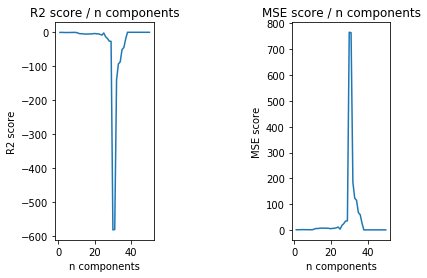

In [72]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [73]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 38 R2 score: 0.4538535162982035
Best n: 38 MSE: 0.7158743057246335


The result seems to improved compared to just using simple Linear Regression.

In [74]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 40 is different from 38)

In [75]:
# Let's check which venue types effect the most and least
print('Max positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('Max negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('Min coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

NameError: name 'pcr_coefs' is not defined

## IV. Conclusion:
This result doesn't seems very good as the R2 score is still small.
Though the machine learning models can be used to predict a neighborhood's average house price,

Based on the observed coefficient correlations, fancy places like restaurants seem to boost real estate's value the most.  
In some ways, it's a logical conclusion. Neighborhoods that have many restaurants are most likely business areas such as downtown. It's where lots of people go to, lots of activities to enjoy, lots of other businesses, ....  The kind of places that people like to live at or closeby.  
And as a result of high demand, the price will be higher than other more rural neighborhoods.  